In [4]:
import numpy as np
import matplotlib.pyplot as plt

from aeons.utils import *
from aeons.endpoint import EndModel, theta_basic, theta_bandwidth, theta_bandwidth_trunc
from aeons.plotting import *
from aeons.regress import *
from theta_samples import call_polychord

In [5]:
# Set default matplotlib figure size to be (4,2)
plt.rcParams['figure.figsize'] = (4,2)

In [2]:
class Regress:
    def __init__(self, logL, X):
        self.logL = np.array(logL)
        self.X = np.array(X)
        self.N = len(logL)
        
    def theta(self, minimiser, x0):
        return minimiser(self.logL, self.X, x0)
    
    def L_sq(self, theta):
        loss = self.logL - full.func(self.X, theta)
        return np.sum(loss**2)
    
    def s(self, theta):
        return np.sqrt(self.L_sq(theta)/self.N)
    
    def logPr(self, theta):
        L_sq = self.L_sq(theta)
        s = np.sqrt(L_sq/self.N)
        return -1/2 * self.N * np.log(2*np.pi*s**2) - L_sq/(2*s**2)
    
    def logZ(self, theta_max=None, details=False):
        logPr_max = self.logPr(theta_max)
        H = self.hess(theta_max)
        D = len(theta_max) + 1
        return logZ_formula(logPr_max, H, D, details)
    
    def hess(self, theta_max=None):
        import torch
        from torch.autograd.functional import hessian
        s = self.s(theta_max)
        logL = torch.from_numpy(self.logL)
        mean = torch.from_numpy(self.X)
        theta_s_max = torch.tensor([*theta_max, s], requires_grad=True)
        def func(theta_s):
            *theta, s = theta_s
            loss = logL - full.func(mean, theta, torched=True)
            L_sq = torch.sum(loss**2)
            return -1/2 * self.N * torch.log(2*torch.pi*s**2) - L_sq/(2*s**2)
        H = hessian(func, theta_s_max)
        return np.array(H)
    
    def covtheta(self, theta_max=None):
        """Redefine to exclude rows/columns with covariance of s"""
        Dtheta = len(theta_max)
        H = self.hess(theta_max)
        return np.linalg.inv(-H[:Dtheta, :Dtheta])

Likelihood model:

$$ \log f_c(X, \theta) = \log L_\mathrm{max} - \frac{1+d}{2} \log \left(1 + \frac{X^{2/d}}{\gamma^2}\right) $$

$$ C^2(\theta) = \sum_i \left[ \log L_i - \log L_\mathrm{max} + \frac{1+d}{2} \log \left(1 + \frac{X^{2/d}}{\gamma^2}\right) \right]^2 $$

Differentiate w.r.t. $\log L_\mathrm{max}$

$$ 2 \sum_i \left[ \log L_i - \log L_\mathrm{max} + \frac{1+d}{2} \log \left(1 + \frac{X^{2/d}}{\gamma^2}\right) \right] = 0 $$

$$ \log L_\mathrm{max} = \frac{1}{N} \sum_i \left[ \log L_i + \frac{1+d}{2} \log \left(1 + \frac{X^{2/d}}{\gamma^2}\right) \right]$$

So if we optimise w.r.t. $d$ and $\gamma$, we can get $\log L_\mathrm{max}$ for free.

Need to choose how we define $\gamma$ carefully for optimization

In [6]:
# Functions for cauchy regression
def logcauchy(X, theta, torched=False):
    logLmax, c, gamma = theta
    if torched:
        import torch
        return logLmax - (1 + c)/2 * torch.log( 1 + X**(2/c)/(gamma**2) )
    return logLmax - (1 + c)/2 * np.log( 1 + X**(2/c)/gamma**2 )

def logLmax_cauchy(logLi, Xi, c, gamma):
    N = len(logLi)
    summand = logLi + (1 + c)/2 * np.log( 1 + Xi**(2/c)/gamma**2 )
    return np.sum(summand)/N

# Direct method
def minimise_cauchy(logL, X, x0):
    Xd = X/X[0]
    def func(theta):
        return np.sum((logL - logcauchy(Xd, theta))**2)
    from scipy.optimize import minimize
    theta = minimize(func, x0, bounds=((None, None), (0, np.inf), (0, np.inf))).x
    theta[2] *= X[0]
    return theta

# Analytic method
def minimise_cauchy_analytic(logL, X, x0):
    def func(theta):
        c, gamma = theta
        logLmax = logLmax_cauchy(logL, X, c, gamma)
        return np.sum((logL - logcauchy(X, [logLmax, c, gamma]))**2)
    from scipy.optimize import minimize
    theta = minimize(func, x0, bounds=((0, np.inf), (0, np.inf))).x
    logLmax = logLmax_cauchy(logL, X, *theta)
    theta = np.array([logLmax, *theta])
    return theta

def minimise_brute(logLlive, Xlive, cs=None, gammas=None):
    if cs is None:
        cs = np.exp(np.linspace(-10, 5, 200))
    if gammas is None:
        gammas = np.exp(np.linspace(-40, -2, 200))
    # Calculate loss for each c, gamma
    loss = np.zeros((len(cs), len(gammas)))
    for i, c in enumerate(cs):
        for j, gamma in enumerate(gammas):
            logLmax = logLmax_cauchy(logLlive, Xlive, c, gamma)
            loss[i, j] = np.sum((logLlive - logcauchy(Xlive, [logLmax, c, gamma]))**2)
        # Print i every 20% of the way
        if i % (len(cs)//5) == 0:
            print(f"{i/len(cs)*100:.0f}%", end='| ')
    return loss, cs, gammas

from scipy.optimize import shgo
def minimise_cauchy_shgo(logL, X, **kwargs):
    def func(theta):
        c, gamma = theta
        logLmax = logLmax_cauchy(logL, X, c, gamma)
        return np.sum((logL - logcauchy(X, [logLmax, c, gamma]))**2)
    bounds = kwargs.pop('bounds', ((0, 1e3), (0, 10)))
    return shgo(func, bounds, **kwargs)

def cauchy_logXf(theta, logZdead, logX0):
    # Do likelihood prediction with theta
    logX_pred = np.linspace(logX0, -200, 2000)
    X_pred = np.exp(logX_pred)
    logL_pred = logcauchy(X_pred, theta)
    dlogX = abs(np.diff(logX_pred)[0])
    logsummands_pred = logL_pred + logX_pred + np.log(dlogX)
    logZ_deads_pred = np.logaddexp(logZdead, np.logaddexp.accumulate(logsummands_pred))
    logZ_tot_pred = logZ_deads_pred[-1]
    log_differences = logZ_deads_pred - logZ_tot_pred
    logZ_fracs_pred = np.log(1 - np.exp(log_differences), where=log_differences != 0)
    return logX_pred[np.argmin(np.abs(logZ_fracs_pred - np.log(1e-3)))]

### Regression

#### Regression method

#### Get data

In [64]:
name, samples = get_samples("toy", "cauchy_10_0001")
model = EndModel(samples)
true_endpoint = model.true_endpoint()
true_logXf = samples.logX().iloc[true_endpoint]
theta_true = [0, 10, 1e-4]

In [186]:
ndead = 30000
logLall, Xall, nk, logZdead = model.data(ndead, live=False)
logLall, Xall = np.array(logLall), np.array(Xall)
Xd = generate_Xs(nk)

window = np.arange(ndead - 5000, len(logLall))
logLd, Xd = logLall[window], Xall[window]

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))


In [187]:
loss, cs, gammas = minimise_brute(logLd, Xd)
# Replace nan with inf in loss
loss[np.isnan(loss)] = np.inf
i, j = np.unravel_index(np.argmin(loss), loss.shape)
theta = [logLmax_cauchy(logLd, Xd, cs[i], gammas[j]), cs[i], gammas[j]]
theta

0%| 20%| 40%| 60%| 80%| 

[219.23575259663875, 7.848335786018558, 1.5991979006008278e-16]

#### Sensitivity checks

/tmp/ipykernel_910694/1131051395.py:61: RuntimeWarning: divide by zero encountered in log
  logZ_fracs_pred = np.log(1 - np.exp(logZ_deads_pred - logZ_tot_pred))


0%| 20%| 40%| 60%| 80%| -199.8999499749875


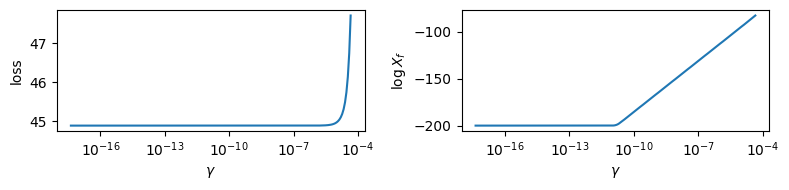

In [209]:
c = theta[1]
gammas = np.exp(np.linspace(-40, -10, 200))
# Calculate loss for each gamma
loss = np.zeros_like(gammas)
logXfs = np.zeros_like(gammas)
for i, gamma in enumerate(gammas):
    logLmax = logLmax_cauchy(logLd, Xd, c, gamma)
    loss[i] = np.sum((logLd - logcauchy(Xd, [logLmax, c, gamma]))**2)
    logXfs[i] = cauchy_logXf([logLmax, c, gamma], logZdead, Xd[0])
    # Print i every 20% of the way
    if i % (len(gammas)//5) == 0:
        print(f"{i/len(gammas)*100:.0f}%", end='| ')
# Plot loss and logXfs for each gamma on logscale
fig, ax = plt.subplots(1, 2, figsize=(8, 2))
ax[0].plot(gammas, loss)
ax[0].set_xlabel(r"$\gamma$")
ax[0].set_ylabel("loss")
ax[0].set_xscale("log")
ax[1].plot(gammas, logXfs)
ax[1].set_xlabel(r"$\gamma$")
ax[1].set_ylabel(r"$\log X_f$")
ax[1].set_xscale("log")
print(logXfs[np.argmin(loss)])
plt.tight_layout()

Text(0.5, 1.0, 'loss=44.96')

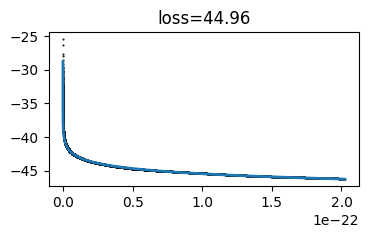

In [202]:
c, gamma = theta[1], 1e-5
logLmax = logLmax_cauchy(logLd, Xd, c, gamma)
plt.plot(Xd, logLd, 'k.', ms=1)
plt.plot(Xd, logcauchy(Xd, [logLmax, c, gamma]), lw=2)
plt.title(f"loss={np.sum((logLd - logcauchy(Xd, [logLmax, c, gamma]))**2):.2f}")

/tmp/ipykernel_910694/1131051395.py:61: RuntimeWarning: divide by zero encountered in log
  logZ_fracs_pred = np.log(1 - np.exp(logZ_deads_pred - logZ_tot_pred))


-152.97648824412204

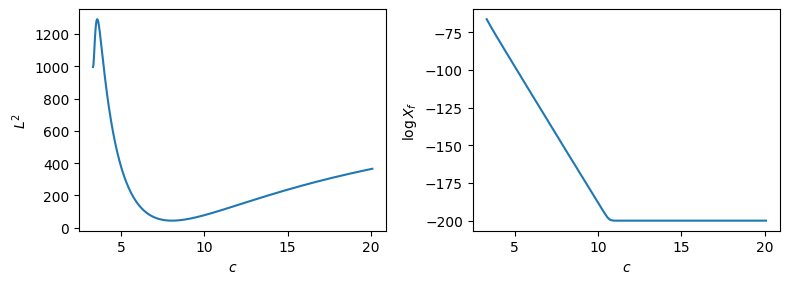

In [184]:
# Plot loss and logXf as a function of c
gamma = 1e-8
cs = np.exp(np.linspace(1.2, 3, 200))
loss = np.zeros_like(cs)
logXfs = np.zeros_like(cs)
for i, c in enumerate(cs):
    logLmax = logLmax_cauchy(logLd, Xd, c, gamma)
    loss[i] = np.sum((logLd - logcauchy(Xd, [logLmax, c, gamma]))**2)
    logXfs[i] = cauchy_logXf([logLmax, c, gamma], logZdead, Xd[0])

# Plot loss and logXf as a function of c
fig, axes = plt.subplots(1, 2, figsize=(8,3))
axes[0].plot(cs, loss)
axes[0].set_xlabel(r"$c$")
axes[0].set_ylabel(r"$L^2$")
axes[1].plot(cs, logXfs)
axes[1].set_xlabel(r"$c$")
axes[1].set_ylabel(r"$\log X_f$")
fig.tight_layout()
logXfs[np.argmin(loss)]

Text(0.5, 1.0, '[0e+00, 10, 1e-04] loss=231.59')

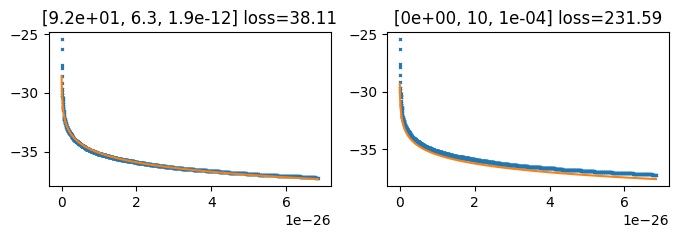

In [145]:
# Plot theta and theta_true on two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 2))
ax1.plot(Xd, logLd, 'x', ms=2)
ax1.plot(Xd, logcauchy(Xd, theta))
ax1.set_title(formatt(theta, 1) + f' loss={np.sum((logLd - logcauchy(Xd, theta))**2):.2f}')
ax2.plot(Xd, logLd, 'x', ms=2)
ax2.plot(Xd, logcauchy(Xd, theta_true))
ax2.set_title(formatt(theta_true, 0) + f' loss={np.sum((logLd - logcauchy(Xd, theta_true))**2):.2f}')

#### Predictions as a Higson plot

/tmp/ipykernel_910694/1131051395.py:61: RuntimeWarning: divide by zero encountered in log
  logZ_fracs_pred = np.log(1 - np.exp(logZ_deads_pred - logZ_tot_pred))


-174.3565778123866

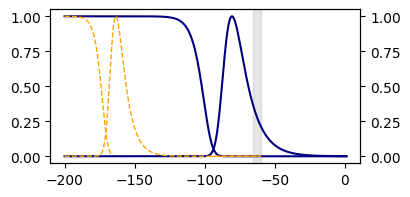

In [152]:
logX = np.linspace(-200, 1, 1000)
Xd = np.exp(logX)
theta_true = [0, 10, 1e-4]
logX_pred = logX[logX < np.log(Xall[ndead])]
logX_known = logX[logX > np.log(Xall[ndead])]
X_pred, X_known = np.exp(logX_pred), np.exp(logX_known)

logL = logcauchy(Xd, theta_true)
logL_known = logcauchy(X_known, theta_true)
logL_pred = logcauchy(X_pred, theta)
logL_pred = np.concatenate([logL_pred, logL_known])
L = np.exp(logL - logL.max())
LX = L*Xd
L_pred = np.exp(logL_pred - logL_pred.max())
LX_pred = L_pred*Xd

# Above plot but using plt.Subplot
fig, ax = plt.subplots(figsize=(4,2))
ax1 = plt.twinx(ax)

ax.plot(logX, L, color='navy')
ax1.plot(logX, LX/LX.max(), color='navy')

ax.plot(logX_pred, L_pred[logX < np.log(Xall[ndead])], color='orange', lw=1, ls='--')
ax1.plot(logX_pred, (LX_pred/LX_pred.max())[logX < np.log(Xall[ndead])], lw=1, color='orange', ls='--')
ax1.axvspan(np.log(Xall[ndead]), np.log(Xall[-1]), color='grey', alpha=0.2)
cauchy_logXf(theta, logZdead, np.log(Xall[ndead]))

In [19]:
cauchy_logXf(samples, ndead, theta_true), true_logXf

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))
/tmp/ipykernel_910694/2363609805.py:62: RuntimeWarning: divide by zero encountered in log
  logZ_fracs_pred = np.log(1 - np.exp(logZ_deads_pred - logZ_tot_pred))


(-95.74477536840402, -95.89613579769184)

### Making some predictions for a pure Cauchy

In [18]:
name, samples = get_samples("toy", "cauchy_10_0001")
model = EndModel(samples)
true_endpoint = model.true_endpoint()
true_logXf = samples.logX().iloc[true_endpoint]

In [19]:
ndead = 20000
logLall, Xall, nk, logZdead = model.data(ndead, live=False)
logLall, Xall = np.array(logLall), np.array(Xall)
window = np.arange(ndead, len(logLall))
logLd, Xd = logLall[window], Xall[window]

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))


In [11]:
from anesthetic import read_chains
theta_samples = read_chains("chains/cauchy_20000")

In [14]:
# Contour plot of c against gamma, gamma on log scale
theta_samples['loggamma'] = np.log(theta_samples['gamma'])

,c,loggamma
c,DiagonalAx...,OffDiagona...
loggamma,OffDiagona...,DiagonalAx...


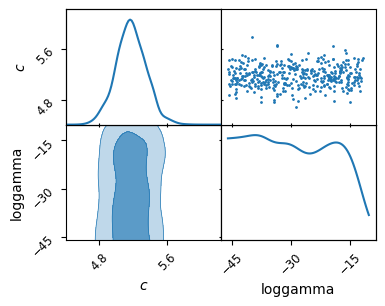

In [22]:
from anesthetic import make_2d_axes
fig, axs = make_2d_axes(['c', 'loggamma'], figsize=(4, 3))
theta_samples.plot_2d(axes=axs)

In [31]:
theta_samples.iloc[::10].recompute()

,,c,gamma,logL,logL_birth,nlive,loggamma
,labels,$c$,$\gamma$,$\ln\mathcal{L}$,$\ln\mathcal{L}_\mathrm{birth}$,$n_\mathrm{live}$,
,weights,,,,,,
0,0.000000e+00,116.625103,9.755297e-01,-609.998518,-inf,43,-0.024775
1,1.955191e-191,969.559372,3.776503e-01,-170.941116,-inf,43,-0.973787
2,9.849591e-112,321.618028,8.702331e-02,12.614082,-inf,43,-2.441579
3,4.151183e-108,873.800208,4.913076e-02,21.005355,-296.364459,44,-3.013270
4,1.697825e-106,615.796089,2.713127e-02,24.749881,21.005355,45,-3.607068
...,...,...,...,...,...,...,...
623,2.303303e-03,5.145709,2.192688e-10,276.228923,276.228883,5,-22.240723
624,2.303303e-03,5.145705,9.552953e-14,276.228923,276.228921,4,-29.979341


In [27]:
theta_samples.iloc[::50].recompute().logZ()

269.5065045648075

#### Fgivenx plots

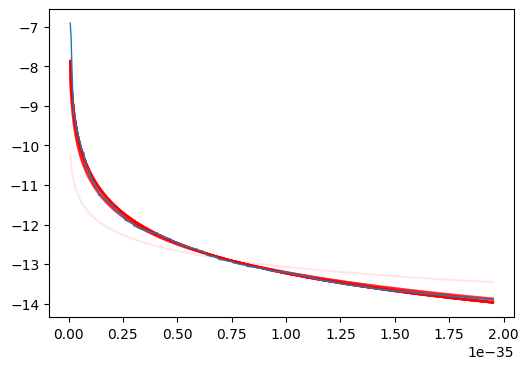

In [11]:
from fgivenx import plot_lines

def f(X, theta):
    c, gamma = theta
    return logcauchy(X, [logLmax_cauchy(logLd, Xd, c, gamma), c, gamma])

fig, ax = plt.subplots(figsize=(6, 4))
params = np.array([(c, gamma) for c, gamma in zip(theta_samples.c.values, theta_samples.gamma.values)])
plot_lines(f, Xd, params, ax, color='r')
ax.plot(Xd, logLd, lw=1)

#### Nested sampling

In [20]:
samples = call_polychord(logLd, Xd, 'chains/cauchy_20000', nlive=50)

: 

: 

In [16]:
from anesthetic import read_chains
theta_samples = read_chains("chains/cauchy_20000").iloc[::10].recompute()

# Calculate cauchy_logXf for each c, gamma in samples
logXfs = np.zeros(len(theta_samples))
endpoints = np.zeros(len(theta_samples))
for i in range(len(theta_samples)):
    c, gamma = theta_samples.c[i], theta_samples.gamma[i]
    logLmax = logLmax_cauchy(logLd, Xd, c, gamma)
    theta = [logLmax, c, gamma]
    logXfs[i] = cauchy_logXf(theta, logZdead, Xall[ndead])
    endpoints[i] = calc_endpoints(ndead, samples.logX().iloc[ndead], logXfs[i], 1e-3, nlive=500)[0]
    # Print every 10% of the way
    if i % (len(theta_samples)//10) == 0:
        print(f"{i/len(theta_samples)*100:.0f}%", end='| ')

0%| 10%| 

KeyboardInterrupt: 

In [9]:
from anesthetic import read_chains
theta_samples = read_chains("chains/cauchy_40000").iloc[::10].recompute()

# Calculate cauchy_logXf for each c, gamma in samples
logXfs = np.zeros(len(theta_samples))
endpoints = np.zeros(len(theta_samples))
for i in range(len(theta_samples)):
    c, gamma = theta_samples.c[i], theta_samples.gamma[i]
    logLmax = logLmax_cauchy(logLd, Xd, c, gamma)
    theta = [logLmax, c, gamma]
    logXfs[i] = cauchy_logXf(theta, logZdead, Xall[ndead])
    endpoints[i] = calc_endpoints(ndead, samples.logX().iloc[ndead], logXfs[i], 1e-3, nlive=500)[0]
    # Print every 10% of the way
    if i % (len(theta_samples)//10) == 0:
        print(f"{i/len(theta_samples)*100:.0f}%", end='| ')

0%| 9%| 19%| 28%| 38%| 47%| 57%| 66%| 76%| 85%| 95%| 

In [10]:
theta_samples['logXfs'] = logXfs
theta_samples['endpoints'] = endpoints
print(theta_samples['logXfs'].mean(), theta_samples['logXfs'].std())
print(theta_samples['endpoints'].mean(), theta_samples['endpoints'].std())

-183.89339194787144 25.44530699345777
91985.64371912916 12722.653496728883


endpoints    Axes(0.064...
dtype: object

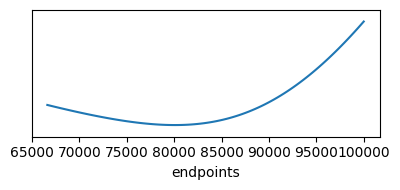

In [14]:
theta_samples.plot_1d('endpoints')

#### Brute force

In [312]:
loss, cs, gammas = minimise_brute(logLd, Xd, cs=np.exp(np.linspace(-10, 5, 200)), gammas=np.exp(np.linspace(-40, -2, 200)))
i, j = np.unravel_index(np.argmin(loss), loss.shape)
theta = [logLmax_cauchy(logLd, Xd, cs[i], gammas[j]), cs[i], gammas[j]]

0%| 20%| 40%| 60%| 80%| 

In [313]:
theta

[85.01075783667659, 3.9824991435102035, 2.8676541310366334e-17]

#### SHGO

In [64]:
from scipy.optimize import shgo
def minimise_cauchy_shgo(logL, X, **kwargs):
    def func(theta):
        c, gamma = theta
        logLmax = logLmax_cauchy(logL, X, c, gamma)
        return np.sum((logL - logcauchy(X, [logLmax, c, gamma]))**2)
    bounds = kwargs.pop('bounds', ((0, 1e3), (0, 10)))
    return shgo(func, bounds, **kwargs)

In [69]:
ndead = 10000
logLall, Xall, nk, logZdead = model.data(ndead, live=False)
logLall, Xall = np.array(logLall), np.array(Xall)
window = np.arange(ndead, len(logLall))
logLd, Xd = logLall[window], Xall[window]

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))


In [70]:
solution = minimise_cauchy_shgo(logLd, Xd, n=64, iters=3, sampling_method='sobol')
c, gamma = solution.x
theta = [logLmax_cauchy(logLd, Xd, c, gamma), c, gamma]
theta

/tmp/ipykernel_946076/594790154.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  summand = logLi + (1 + c)/2 * np.log( 1 + Xi**(2/c)/gamma**2 )
/tmp/ipykernel_946076/594790154.py:11: RuntimeWarning: invalid value encountered in divide
  summand = logLi + (1 + c)/2 * np.log( 1 + Xi**(2/c)/gamma**2 )
/tmp/ipykernel_946076/594790154.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  return logLmax - (1 + c)/2 * np.log( 1 + X**(2/c)/gamma**2 )
/tmp/ipykernel_946076/594790154.py:7: RuntimeWarning: invalid value encountered in divide
  return logLmax - (1 + c)/2 * np.log( 1 + X**(2/c)/gamma**2 )
/tmp/ipykernel_946076/594790154.py:11: RuntimeWarning: divide by zero encountered in divide
  summand = logLi + (1 + c)/2 * np.log( 1 + Xi**(2/c)/gamma**2 )
/tmp/ipykernel_946076/594790154.py:7: RuntimeWarning: divide by zero encountered in divide
  return logLmax - (1 + c)/2 * np.log( 1 + X**(2/c)/gamma**2 )
/tmp/ipykernel_946076/594790154.py:7: RuntimeWarning: i

[94.17448481679789, 3.99516721393608, 5.0606866192585996e-18]

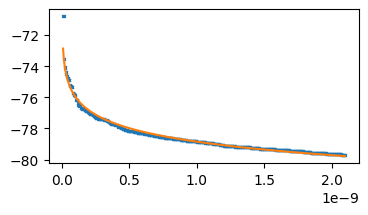

In [66]:
# Plot theta
fig, ax = plt.subplots(figsize=(4,2))
ax.plot(Xd, logLd, 'x', ms=2)
ax.plot(Xd, logcauchy(Xd, theta))

In [71]:
logXf = cauchy_logXf(theta, logZdead, np.log(Xall[ndead]))
logXf, true_logXf, calc_endpoints(ndead, np.log(Xall[ndead]), logXf, 1e-3, nlive=500)

(-164.87893349258718, -95.89613579769184, (82448.45642362462, 0.5))

In [92]:
ndead = 40000
logLall, Xall, nk, logZdead = model.data(ndead, live=False)
logLall, Xall = np.array(logLall), np.array(Xall)
window = np.arange(ndead, len(logLall))
logLd, Xd = logLall[window], Xall[window]

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))


In [93]:
Nset = 25
logXfs = np.zeros(Nset)
for i in range(Nset):
    X = generate_Xs(nk)[window]
    c, gamma = minimise_cauchy_shgo(logLd, X, n=64, iters=3, sampling_method='sobol').x
    theta = [logLmax_cauchy(logLd, X, c, gamma), c, gamma]
    logXfs[i] = cauchy_logXf(theta, logZdead, np.log(X[0]))
    # Print every 10% of the way
    if i % (Nset//10) == 0:
        print(f"{i/Nset*100:.0f}%", end='| ')

/tmp/ipykernel_946076/594790154.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  summand = logLi + (1 + c)/2 * np.log( 1 + Xi**(2/c)/gamma**2 )
/tmp/ipykernel_946076/594790154.py:11: RuntimeWarning: invalid value encountered in divide
  summand = logLi + (1 + c)/2 * np.log( 1 + Xi**(2/c)/gamma**2 )
/tmp/ipykernel_946076/594790154.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  return logLmax - (1 + c)/2 * np.log( 1 + X**(2/c)/gamma**2 )
/tmp/ipykernel_946076/594790154.py:7: RuntimeWarning: invalid value encountered in divide
  return logLmax - (1 + c)/2 * np.log( 1 + X**(2/c)/gamma**2 )
/tmp/ipykernel_946076/594790154.py:11: RuntimeWarning: divide by zero encountered in divide
  summand = logLi + (1 + c)/2 * np.log( 1 + Xi**(2/c)/gamma**2 )
/tmp/ipykernel_946076/594790154.py:7: RuntimeWarning: divide by zero encountered in divide
  return logLmax - (1 + c)/2 * np.log( 1 + X**(2/c)/gamma**2 )
/tmp/ipykernel_946076/594790154.py:7: RuntimeWarning: i

0%| 8%| 16%| 24%| 32%| 40%| 48%| 56%| 64%| 72%| 80%| 88%| 96%| 

In [94]:
endpoints, endpoints_std = calc_endpoints(ndead, np.log(Xall[ndead]), logXfs.mean(), logXfs.std(), nlive=500)
endpoints, endpoints_std

(94504.31316485099, 13475.866352067795)

### Predictions for GP samples

In [352]:
name, samples = get_samples("toy", "gp")
model = EndModel(samples)
true_endpoint = model.true_endpoint()
true_logXf = samples.logX().iloc[true_endpoint]

In [384]:
ndead = 30000
logLall, Xall, nk, logZdead = model.data(ndead, live=False)
logLall, Xall = np.array(logLall), np.array(Xall)
window = np.arange(ndead, len(logLall))
logLd, Xd = logLall[window], Xall[window]

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))


/tmp/ipykernel_910694/594790154.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  summand = logLi + (1 + c)/2 * np.log( 1 + Xi**(2/c)/gamma**2 )
/tmp/ipykernel_910694/594790154.py:11: RuntimeWarning: invalid value encountered in divide
  summand = logLi + (1 + c)/2 * np.log( 1 + Xi**(2/c)/gamma**2 )
/tmp/ipykernel_910694/594790154.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  return logLmax - (1 + c)/2 * np.log( 1 + X**(2/c)/gamma**2 )
/tmp/ipykernel_910694/594790154.py:7: RuntimeWarning: invalid value encountered in divide
  return logLmax - (1 + c)/2 * np.log( 1 + X**(2/c)/gamma**2 )
/tmp/ipykernel_910694/594790154.py:11: RuntimeWarning: divide by zero encountered in divide
  summand = logLi + (1 + c)/2 * np.log( 1 + Xi**(2/c)/gamma**2 )
/tmp/ipykernel_910694/594790154.py:7: RuntimeWarning: divide by zero encountered in divide
  return logLmax - (1 + c)/2 * np.log( 1 + X**(2/c)/gamma**2 )
/tmp/ipykernel_910694/594790154.py:7: RuntimeWarning: i

Text(0.5, 1.0, '[8.4e+03, 3.3, 1.3e-08] loss=9475.54')

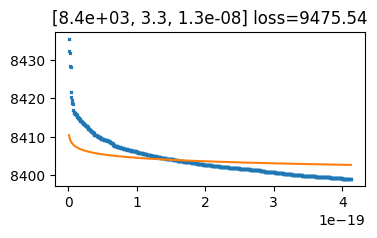

In [385]:
sol = minimise_cauchy_shgo(logLd, Xd, n=128, iters=5, sampling_method='sobol', bounds=((0, 1e3), (0, 1e1)))
c, gamma = sol.x
theta = [logLmax_cauchy(logLd, Xd, c, gamma), c, gamma]

# Plot theta
fig, ax = plt.subplots(figsize=(4,2))
ax.plot(Xd, logLd, 'x', ms=2)
ax.plot(Xd, logcauchy(Xd, theta))
ax.set_title(f"{formatt(theta, 1)} loss={sol.fun:.2f}")

### Demonstration of lack of support

In [1]:
name, samples = get_samples("lcdm", "SH0ES")
model = EndModel(samples)
true_endpoint = model.true_endpoint()
true_logXf = samples.logX().iloc[true_endpoint]

NameError: name 'get_samples' is not defined

In [147]:
ndead = 14000
logLall, Xall, nk, logZdead = model.data(ndead, live=False)
logLall, Xall = np.array(logLall), np.array(Xall)
window = np.arange(ndead, len(logLall))
logLd, Xd = logLall[window], Xall[window]

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))


In [148]:
samples.logX().iloc[ndead]

-7.3001867534123965

/tmp/ipykernel_946076/594790154.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  summand = logLi + (1 + c)/2 * np.log( 1 + Xi**(2/c)/gamma**2 )
/tmp/ipykernel_946076/594790154.py:11: RuntimeWarning: invalid value encountered in divide
  summand = logLi + (1 + c)/2 * np.log( 1 + Xi**(2/c)/gamma**2 )
/tmp/ipykernel_946076/594790154.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  return logLmax - (1 + c)/2 * np.log( 1 + X**(2/c)/gamma**2 )
/tmp/ipykernel_946076/594790154.py:7: RuntimeWarning: invalid value encountered in divide
  return logLmax - (1 + c)/2 * np.log( 1 + X**(2/c)/gamma**2 )
/tmp/ipykernel_946076/594790154.py:11: RuntimeWarning: divide by zero encountered in divide
  summand = logLi + (1 + c)/2 * np.log( 1 + Xi**(2/c)/gamma**2 )
/tmp/ipykernel_946076/594790154.py:7: RuntimeWarning: divide by zero encountered in divide
  return logLmax - (1 + c)/2 * np.log( 1 + X**(2/c)/gamma**2 )
/tmp/ipykernel_946076/594790154.py:7: RuntimeWarning: i

Text(0.5, 1.0, '[-3.9e+00, 3.3, 1.4e-01] loss=0.05')

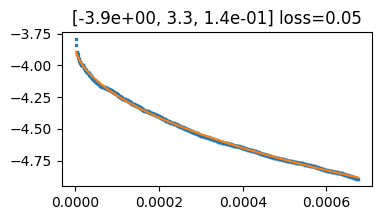

In [151]:
c, gamma = minimise_cauchy_shgo(logLd, Xd, n=64, iters=5, sampling_method='sobol').x
theta = [logLmax_cauchy(logLd, Xd, c, gamma), c, gamma]
plt.plot(Xd, logLd, 'x', ms=2)
plt.plot(Xd, logcauchy(Xd, theta))
plt.title(f"{formatt(theta, 1)} loss={np.sum((logLd - logcauchy(Xd, theta))**2):.2f}")

In [152]:
logXf = cauchy_logXf(theta, logZdead, np.log(Xall[ndead]))
endpoint = calc_endpoints(ndead, np.log(Xall[ndead]), logXf, 1e-3, nlive=1000)[0]
print(f"estimate: {endpoint}, true: {true_endpoint}")
print(logXf, true_logXf)

estimate: 20555.071219926074, true: 20672
-13.855256975334562 -13.968852975746193
